# Conectar a base de datos y extraer tablas
AdventureWorks es una base de datos de ejemplo proporcionada por Microsoft, utilizada principalmente para demostraciones, pruebas y aprendizaje. Representa un entorno de datos ficticio pero realista basado en una empresa de fabricación y venta de bicicletas. La versión actual AdventureWorks2022, proporciona datos entre 2011-05-31 y 2014-06-30.

In [367]:
# Importar librerías
import pyodbc as pyodbc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [369]:
# Realizar la conexión con la base de datos
conn = pyodbc.connect(
    "DRIVER={SQL Server};"
    "SERVER=LAPTOP-KFKKDC80;"
    "DATABASE=AdventureWorks2022;"
    "Trusted_Connection=yes;"
)

In [370]:
conn

In [371]:
# Crear una función, la llamo "consulta" y dento pegaré la consulta SQL que necesite hacer en cada caso
def consulta(query):                       
    cursor = conn.cursor()
    cursor.execute(query)
    rows = cursor.fetchall()
    columns = [i[0] for i in cursor.description]
    df = pd.DataFrame.from_records(
        rows,
        columns = columns
    )
    return df

In [372]:
# Consulta para traer las ventas y costes
consulta = """
SELECT
    soh.ShipDate AS FechaExpedicion,
    sod.ProductID AS IDProducto,
    pc.Name AS Categoria,
    p.Name AS Producto,
    sod.OrderQty AS CantidadVendida,
    sod.UnitPrice AS PrecioVenta,
    sod.UnitPriceDiscount AS Descuento,
    p.StandardCost AS CosteEstandar,
    p.ListPrice AS PrecioCatalogo,
    soh.CustomerID AS IDCliente, 
    c.TerritoryID AS IDTerritorio,
    st.Name AS Territorio,
    st.[Group] AS ZonaGeografica
FROM Sales.SalesOrderDetail sod
JOIN Sales.SalesOrderHeader soh ON sod.SalesOrderID = soh.SalesOrderID
JOIN Production.Product p ON sod.ProductID = p.ProductID
JOIN Production.ProductSubcategory ps ON p.ProductSubcategoryID = ps.ProductSubcategoryID
JOIN Production.ProductCategory pc ON ps.ProductCategoryID = pc.ProductCategoryID
JOIN Sales.Customer c ON soh.CustomerID = c.CustomerID
JOIN Sales.SalesTerritory st ON c.TerritoryID = st.TerritoryID;
"""

In [373]:
# Cargar los datos en un DataFrame:
rentabilidad = pd.read_sql(consulta, conn)

C:\Users\virgi\AppData\Local\Temp\ipykernel_6196\3932765610.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  rentabilidad = pd.read_sql(consulta, conn)


In [374]:
rentabilidad.head()

,FechaExpedicion,IDProducto,Categoria,Producto,CantidadVendida,PrecioVenta,Descuento,CosteEstandar,PrecioCatalogo,IDCliente,IDTerritorio,Territorio,ZonaGeografica
0,2011-06-07,776,Bikes,"Mountain-100 Black, 42",1,2024.994,0.0,1898.0944,3374.99,29825,5,Southeast,North America
1,2011-06-07,777,Bikes,"Mountain-100 Black, 44",3,2024.994,0.0,1898.0944,3374.99,29825,5,Southeast,North America
2,2011-06-07,778,Bikes,"Mountain-100 Black, 48",1,2024.994,0.0,1898.0944,3374.99,29825,5,Southeast,North America
3,2011-06-07,771,Bikes,"Mountain-100 Silver, 38",1,2039.994,0.0,1912.1544,3399.99,29825,5,Southeast,North America
4,2011-06-07,772,Bikes,"Mountain-100 Silver, 42",1,2039.994,0.0,1912.1544,3399.99,29825,5,Southeast,North America


In [375]:
rentabilidad.shape

(121317, 13)

# Calcular nuevas columnas

In [377]:
# Extraer el año de cada venta:
rentabilidad["Year"] = rentabilidad["FechaExpedicion"].dt.year

## INGRESOS
CantidadVentidad * (PrecioVenta - (PrecioVenta * Descuento))

In [379]:
rentabilidad["Ingresos"] = rentabilidad["CantidadVendida"] * (rentabilidad["PrecioVenta"] - (rentabilidad["PrecioVenta"] * rentabilidad["Descuento"]))

## COSTES
CantidadVendida * CosteEstandar

In [381]:
rentabilidad["Costes"] = rentabilidad["CantidadVendida"] * rentabilidad["CosteEstandar"]

## MARGEN BRUTO
Ingresos - Costes / Ingresos

In [383]:
rentabilidad["MargenBruto"] = (rentabilidad["Ingresos"] - rentabilidad["Costes"]) / rentabilidad["Ingresos"]

In [384]:
rentabilidad.head()

,FechaExpedicion,IDProducto,Categoria,Producto,CantidadVendida,PrecioVenta,Descuento,CosteEstandar,PrecioCatalogo,IDCliente,IDTerritorio,Territorio,ZonaGeografica,Year,Ingresos,Costes,MargenBruto
0,2011-06-07,776,Bikes,"Mountain-100 Black, 42",1,2024.994,0.0,1898.0944,3374.99,29825,5,Southeast,North America,2011,2024.994,1898.0944,0.062667
1,2011-06-07,777,Bikes,"Mountain-100 Black, 44",3,2024.994,0.0,1898.0944,3374.99,29825,5,Southeast,North America,2011,6074.982,5694.2832,0.062667
2,2011-06-07,778,Bikes,"Mountain-100 Black, 48",1,2024.994,0.0,1898.0944,3374.99,29825,5,Southeast,North America,2011,2024.994,1898.0944,0.062667
3,2011-06-07,771,Bikes,"Mountain-100 Silver, 38",1,2039.994,0.0,1912.1544,3399.99,29825,5,Southeast,North America,2011,2039.994,1912.1544,0.062667
4,2011-06-07,772,Bikes,"Mountain-100 Silver, 42",1,2039.994,0.0,1912.1544,3399.99,29825,5,Southeast,North America,2011,2039.994,1912.1544,0.062667


## BENEFICIO NETO

In [386]:
rentabilidad["Beneficio"] = rentabilidad["Ingresos"] - rentabilidad["Costes"]
rentabilidad.head()

,FechaExpedicion,IDProducto,Categoria,Producto,CantidadVendida,PrecioVenta,Descuento,CosteEstandar,PrecioCatalogo,IDCliente,IDTerritorio,Territorio,ZonaGeografica,Year,Ingresos,Costes,MargenBruto,Beneficio
0,2011-06-07,776,Bikes,"Mountain-100 Black, 42",1,2024.994,0.0,1898.0944,3374.99,29825,5,Southeast,North America,2011,2024.994,1898.0944,0.062667,126.8996
1,2011-06-07,777,Bikes,"Mountain-100 Black, 44",3,2024.994,0.0,1898.0944,3374.99,29825,5,Southeast,North America,2011,6074.982,5694.2832,0.062667,380.6988
2,2011-06-07,778,Bikes,"Mountain-100 Black, 48",1,2024.994,0.0,1898.0944,3374.99,29825,5,Southeast,North America,2011,2024.994,1898.0944,0.062667,126.8996
3,2011-06-07,771,Bikes,"Mountain-100 Silver, 38",1,2039.994,0.0,1912.1544,3399.99,29825,5,Southeast,North America,2011,2039.994,1912.1544,0.062667,127.8396
4,2011-06-07,772,Bikes,"Mountain-100 Silver, 42",1,2039.994,0.0,1912.1544,3399.99,29825,5,Southeast,North America,2011,2039.994,1912.1544,0.062667,127.8396


## MARGEN NETO
AdventureWorks no tiene datos financieros completos (costes indirectos, amortizaciones, etc), por lo que no se puede calcular el margen neto real. Nos centraremos en analizar a rentabilidad a nivel operativo.

## MARGEN ANUAL

In [388]:
margen_anual = rentabilidad.groupby(["Year", "Categoria"]).agg({
    "Ingresos": "sum",
    "Costes": "sum",
    "Beneficio": "sum"
}).reset_index()

# Calcular el margen bruto sobre los totales
margen_anual["MargenBruto"] = (margen_anual["Ingresos"] - margen_anual["Costes"]) / margen_anual["Ingresos"]
margen_anual

,Year,Categoria,Ingresos,Costes,Beneficio,MargenBruto
0,2011,Accessories,2.082077e+04,1.350506e+04,7.315712e+03,0.351366
1,2011,Bikes,1.183196e+07,1.024704e+07,1.584920e+06,0.133952
2,2011,Clothing,3.603148e+04,4.559335e+04,-9.561876e+03,-0.265376
3,2011,Components,6.391730e+05,6.400689e+05,-8.958766e+02,-0.001402
4,2012,Accessories,9.687677e+04,6.561010e+04,3.126667e+04,0.322747
5,2012,Bikes,2.684949e+07,2.595890e+07,8.905856e+05,0.033170
6,2012,Clothing,5.139039e+05,4.420699e+05,7.183408e+04,0.139781
7,2012,Components,3.697527e+06,3.616078e+06,8.144838e+04,0.022028
8,2013,Accessories,6.466849e+05,3.290312e+05,3.176537e+05,0.491203
9,2013,Bikes,3.584913e+07,3.347023e+07,2.378894e+06,0.066358


# Análisis exploratorio

## Distribución del margen bruto

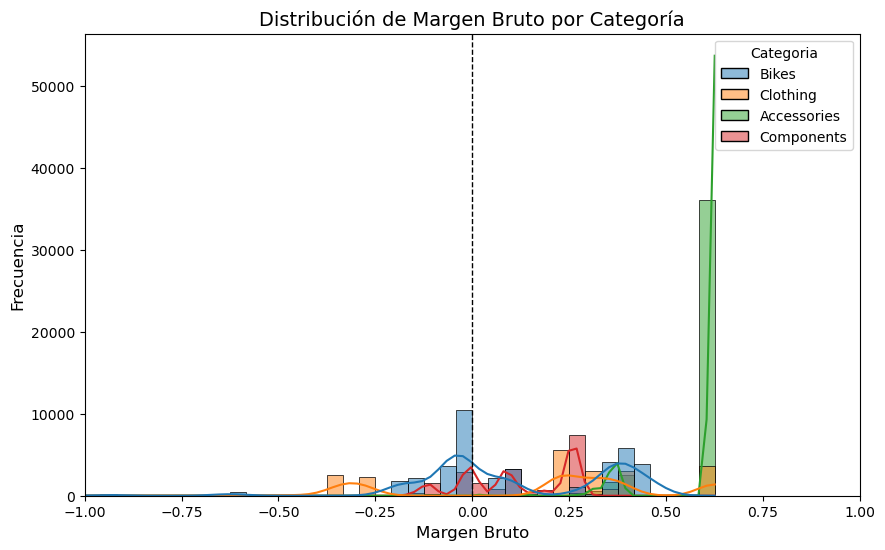

In [391]:
plt.figure(figsize=(10, 6))  
sns.histplot(
    data=rentabilidad,
    x="MargenBruto",
    hue="Categoria",
    kde=True, 
    bins=100,  
    alpha=0.5
)

plt.xlim(-1, 1)
plt.title('Distribución de Margen Bruto por Categoría', fontsize=14)
plt.xlabel('Margen Bruto', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)

plt.show()


## Evolución del margen bruto

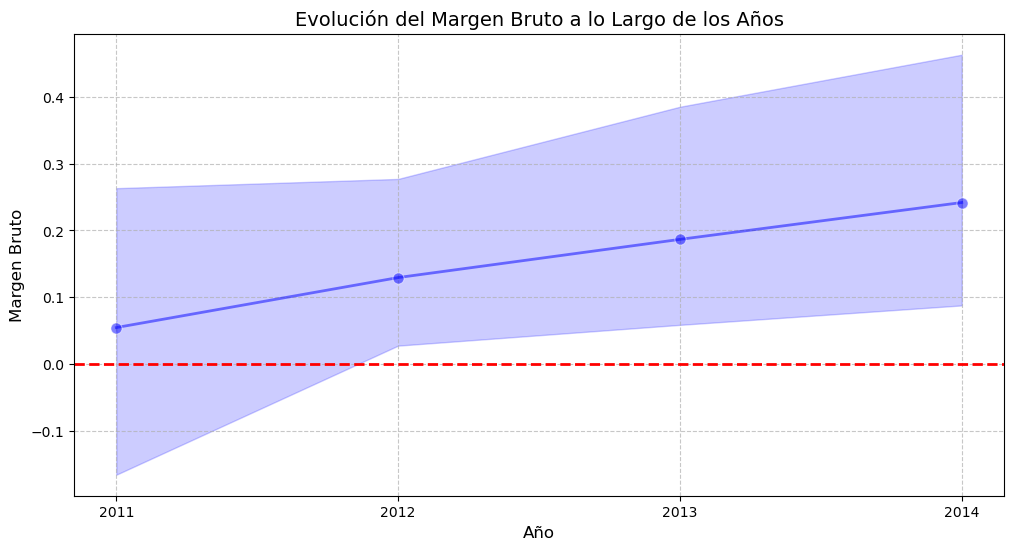

In [393]:
plt.figure(figsize=(12, 6))  # Ajustamos el tamaño del gráfico

sns.lineplot(
    data=margen_anual,
    x="Year",
    y="MargenBruto",
    color='blue',  
    linewidth=2,  
    marker='o',  
    markersize=8,  
    linestyle='-',  
    alpha=0.5  
)

plt.title("Evolución del Margen Bruto a lo Largo de los Años", fontsize=14)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Margen Bruto', fontsize=12)
# Establecemos que solo aparezcan los años enteros, eliminamos los valores intermedios (como 2011.5, 2012.5, etc.)
years = margen_anual['Year'].unique()
plt.xticks(years)  
plt.grid(True, linestyle='--', alpha=0.7)  # Añadimos una cuadrícula discontinua para mejorar la visualización
# Añadir una línea de referencia en Y=0
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)  # Línea horizontal discontinua en 0

plt.show()


## Rentabilidad por categoría

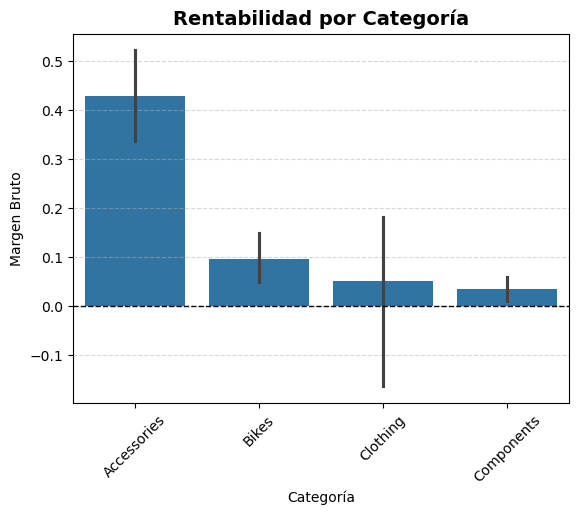

In [396]:
# Graficar
sns.barplot(
    data = margen_anual,
    x = "Categoria",
    y = "MargenBruto",
)
plt.xlabel("Categoría")
plt.ylabel("Margen Bruto")
plt.title("Rentabilidad por Categoría", fontsize=14, fontweight='bold')
# Mejorar visibilidad del gráfico
plt.xticks(rotation=45)  # Rotar etiquetas para mejor lectura
plt.axhline(0, color="black", linestyle="--", linewidth=1)  # Línea de referencia en 0
plt.grid(axis="y", linestyle="--", alpha=0.5)  # Grid suave en eje Y


plt.show()

## Relación entre rentabilidad y precio venta

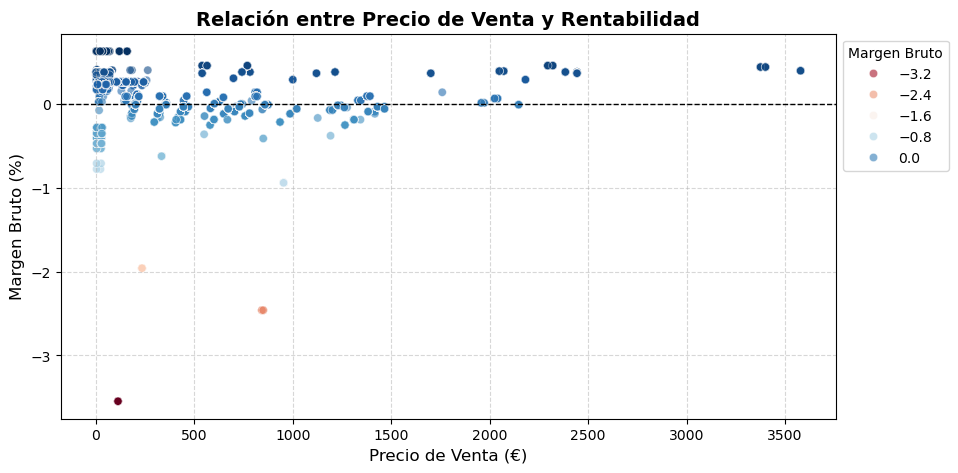

In [401]:
plt.figure(figsize = (10,5))
sns.scatterplot(
    data = rentabilidad,
    x = "PrecioVenta",
    y = "MargenBruto",
    hue="MargenBruto",  # Color según margen bruto
    # size="PrecioVenta",  # Tamaño basado en precio de venta
    sizes=(20, 200),     # Ajustar tamaños de los puntos
    alpha=0.6,           # Hacer los puntos semitransparentes
    palette="RdBu"   # Colores de azul (bajo margen) a rojo (alto margen)
)
# Personalizar el gráfico
plt.axhline(0, color='black', linestyle='--', linewidth=1)  # Línea base en 0
plt.xlabel("Precio de Venta (€)", fontsize=12)
plt.ylabel("Margen Bruto (%)", fontsize=12)
plt.title("Relación entre Precio de Venta y Rentabilidad", fontsize=14, fontweight='bold')

# Ajustar ejes para mejor visibilidad
# plt.xlim(rentabilidad["PrecioVenta"].min() * 0.9, rentabilidad["PrecioVenta"].max() * 1.1)
# plt.ylim(rentabilidad["MargenBruto"].min() * 1.1, rentabilidad["MargenBruto"].max() * 1.1)

# Mover la leyenda
plt.legend(title="Margen Bruto", bbox_to_anchor=(1, 1), loc="upper left")
# Agregar grid
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()

## Relación entre rentabilidad y descuento aplicado

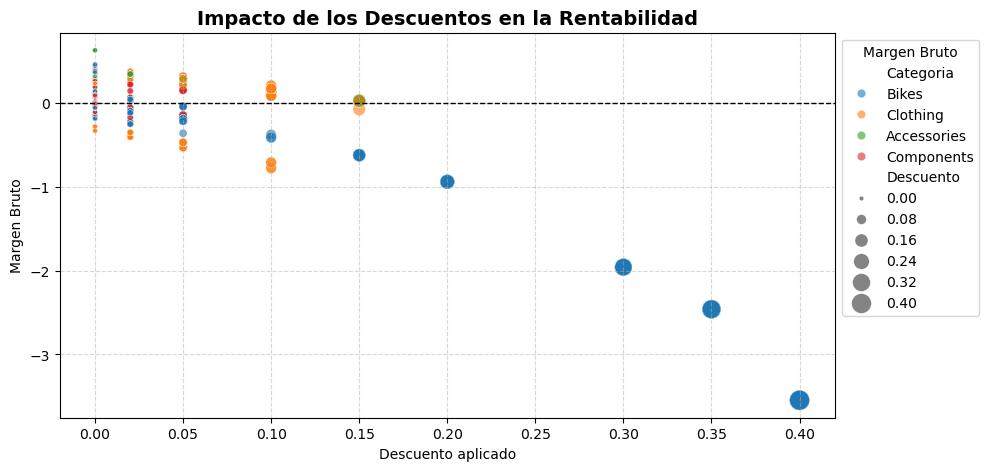

In [403]:
plt.figure(figsize = (10,5))
sns.scatterplot(
    data = rentabilidad,
    x = "Descuento",
    y = "MargenBruto",
    hue="Categoria",  # Colorear según la rentabilidad
    size="Descuento",   # Variar el tamaño según el descuento
    sizes=(10, 200),    # Definir un rango de tamaños de puntos
    alpha=0.6,          # Hacer los puntos semitransparentes
    #palette="RdBu"  # Colores de azul a rojo según valores
)
# Personalizar el gráfico
plt.axhline(0, color='black', linestyle='--', linewidth=1)  # Línea base en margen 0
plt.xlabel("Descuento aplicado")
plt.ylabel("Margen Bruto")
plt.title("Impacto de los Descuentos en la Rentabilidad", fontsize=14, fontweight='bold')
# Mover leyenda a la derecha
plt.legend(title="Margen Bruto", bbox_to_anchor=(1, 1)) 
# Agregar líneas de referencia
plt.grid(True, linestyle="--", alpha=0.5)  

plt.show()

In [404]:
print(rentabilidad["MargenBruto"].describe())

count    121317.000000
mean          0.283743
std           0.348696
min          -3.546067
25%           0.001000
50%           0.351730
75%           0.625992
max           0.626001
Name: MargenBruto, dtype: float64


In [405]:
print(rentabilidad["Descuento"].describe())

count    121317.000000
mean          0.002826
std           0.024811
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           0.400000
Name: Descuento, dtype: float64


In [406]:
print(rentabilidad["Ingresos"].describe())

count    121317.000000
mean        905.449207
std        1693.417389
min           1.374000
25%          24.990000
50%         134.982000
75%        1120.490000
max       27893.619000
Name: Ingresos, dtype: float64


In [407]:
rentabilidad["PrecioVenta"].describe()

count    121317.000000
mean        465.093496
std         751.885081
min           1.328200
25%          21.490000
50%          49.990000
75%         602.346000
max        3578.270000
Name: PrecioVenta, dtype: float64

In [408]:
rentabilidad[ rentabilidad["MargenBruto"] < -1 ].count()


FechaExpedicion    367
IDProducto         367
Categoria          367
Producto           367
CantidadVendida    367
PrecioVenta        367
Descuento          367
CosteEstandar      367
PrecioCatalogo     367
IDCliente          367
IDTerritorio       367
Territorio         367
ZonaGeografica     367
Year               367
Ingresos           367
Costes             367
MargenBruto        367
Beneficio          367
dtype: int64

Estrategia para Gestionar los datos con márgen negativo extremo

1.	Análisis separado:
* Crear un informe específico para estudiar estos casos en profundidad.
* Identificar productos, clientes y fechas más afectadas.
* Evaluar si es un problema puntual o recurrente.

2.	Excluir del análisis de rentabilidad global:
* Mantenerlos fuera de los cálculos principales de margen bruto.
* Incluir un indicador de "ventas por debajo de coste" para seguimiento.


# Análisis de datos con margen negativo extremo

In [411]:
# Crear dataframe para analizar esto datos
productos_negativos = rentabilidad[rentabilidad["MargenBruto"] < -1]

In [412]:
# Añadir columna de pérdidas
productos_negativos["Perdida"] = productos_negativos["Ingresos"] - productos_negativos["Costes"]
productos_negativos = productos_negativos.sort_values(by="Perdida", ascending=True)
productos_negativos.head()

C:\Users\virgi\AppData\Local\Temp\ipykernel_6196\3490667270.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  productos_negativos["Perdida"] = productos_negativos["Ingresos"] - productos_negativos["Costes"]


,FechaExpedicion,IDProducto,Categoria,Producto,CantidadVendida,PrecioVenta,Descuento,CosteEstandar,PrecioCatalogo,IDCliente,IDTerritorio,Territorio,ZonaGeografica,Year,Ingresos,Costes,MargenBruto,Beneficio,Perdida
10333,2012-05-07,776,Bikes,"Mountain-100 Black, 42",11,843.7475,0.35,1898.0944,3374.99,29562,4,Southwest,North America,2012,6032.794625,20879.0384,-2.460923,-14846.243775,-14846.243775
10321,2012-05-07,777,Bikes,"Mountain-100 Black, 44",10,843.7475,0.35,1898.0944,3374.99,29562,4,Southwest,North America,2012,5484.358750,18980.9440,-2.460923,-13496.585250,-13496.585250
10339,2012-05-07,771,Bikes,"Mountain-100 Silver, 38",9,849.9975,0.35,1912.1544,3399.99,29562,4,Southwest,North America,2012,4972.485375,17209.3896,-2.460923,-12236.904225,-12236.904225
9787,2012-05-07,771,Bikes,"Mountain-100 Silver, 38",9,849.9975,0.35,1912.1544,3399.99,29722,6,Canada,North America,2012,4972.485375,17209.3896,-2.460923,-12236.904225,-12236.904225
9943,2012-05-07,775,Bikes,"Mountain-100 Black, 38",9,843.7475,0.35,1898.0944,3374.99,29690,1,Northwest,North America,2012,4935.922875,17082.8496,-2.460923,-12146.926725,-12146.926725


## Pérdidas originadas por artículo

In [414]:
productos_resumen = productos_negativos.groupby(["Year", "Categoria", "IDProducto", "Producto"]).agg({
    "CantidadVendida": "sum",  
    "Ingresos": "sum",  
    "Costes": "sum",  
    "Descuento": "mean",
    "MargenBruto": "mean",  
    "Perdida": "sum",
    "Territorio": "count" 
}).reset_index().rename(columns={"Territorio": "Recuento de ventas"})

In [415]:
# veamos las pérdidas 
productos_resumen

,Year,Categoria,IDProducto,Producto,CantidadVendida,Ingresos,Costes,Descuento,MargenBruto,Perdida,Recuento de ventas
0,2012,Bikes,762,"Road-650 Red, 44",304,49986.081600,147958.8064,0.30,-1.960000,-97972.724800,61
1,2012,Bikes,771,"Mountain-100 Silver, 38",65,35912.394375,124290.0360,0.35,-2.460923,-88377.641625,19
2,2012,Bikes,772,"Mountain-100 Silver, 42",53,29282.413875,101344.1832,0.35,-2.460923,-72061.769325,16
3,2012,Bikes,773,"Mountain-100 Silver, 44",49,27072.420375,93695.5656,0.35,-2.460923,-66623.145225,19
4,2012,Bikes,774,"Mountain-100 Silver, 48",40,22099.935000,76486.1760,0.35,-2.460923,-54386.241000,14
5,2012,Bikes,775,"Mountain-100 Black, 38",70,38390.511250,132866.6080,0.35,-2.460923,-94476.096750,17
6,2012,Bikes,776,"Mountain-100 Black, 42",60,32906.152500,113885.6640,0.35,-2.460923,-80979.511500,18
7,2012,Bikes,777,"Mountain-100 Black, 44",58,31809.280750,110089.4752,0.35,-2.460923,-78280.194450,14
8,2012,Bikes,778,"Mountain-100 Black, 48",61,33454.588375,115783.7584,0.35,-2.460923,-82329.170025,20
9,2014,Bikes,984,"Mountain-500 Silver, 40",65,4406.922000,20034.1635,0.40,-3.546067,-15627.241500,31


In [416]:
# Total pérdidas acumuladas
productos_resumen.Perdida.sum()

-807326.5909000001

In [417]:
# Pérdidas por año
perdidas_year = productos_resumen.groupby(["Year"]).agg({
    "Perdida": "sum"
})
perdidas_year

,Perdida
Year,
2012,-715486.4947
2014,-91840.0962


In [418]:
# Ventas totales
ventas_totales = rentabilidad.groupby("Producto").agg({
    "CantidadVendida": "sum",  
    "Ingresos": "sum",
    "Costes": "sum",
    "MargenBruto": "mean",
    "IDProducto": "count"
}).reset_index()
ventas_totales = ventas_totales.rename(columns={"IDProducto": "Recuento de ventas"})
ventas_totales

,Producto,CantidadVendida,Ingresos,Costes,MargenBruto,Recuento de ventas
0,AWC Logo Cap,8311,51229.445623,57531.2353,0.033920,3382
1,All-Purpose Bike Stand,249,39591.000000,14807.0340,0.626000,249
2,Bike Wash - Dissolver,3319,18406.972080,9868.3827,0.545053,1327
3,Cable Lock,1087,16240.220000,11209.6875,0.311471,260
4,Chain,774,9377.710144,6955.6284,0.259503,250
...,...,...,...,...,...,...
261,"Women's Mountain Shorts, M",1139,57685.758000,29814.8057,0.505543,681
262,"Women's Mountain Shorts, S",3296,137164.127325,86277.0848,0.480660,648
263,"Women's Tights, L",2123,94090.642908,65671.6082,0.309049,441
264,"Women's Tights, M",394,17727.636000,12187.7596,0.312499,114


In [419]:
# Unir ventas totales con ventas con rentabilidad negativa extrema
productos_resumen = productos_resumen.merge(
    ventas_totales[["Producto", "CantidadVendida", "Recuento de ventas"]],
    on="Producto",
    how="left",
    suffixes=("", "_Total")
)

productos_resumen

,Year,Categoria,IDProducto,Producto,CantidadVendida,Ingresos,Costes,Descuento,MargenBruto,Perdida,Recuento de ventas,CantidadVendida_Total,Recuento de ventas_Total
0,2012,Bikes,762,"Road-650 Red, 44",304,49986.081600,147958.8064,0.30,-1.960000,-97972.724800,61,2254,689
1,2012,Bikes,771,"Mountain-100 Silver, 38",65,35912.394375,124290.0360,0.35,-2.460923,-88377.641625,19,642,241
2,2012,Bikes,772,"Mountain-100 Silver, 42",53,29282.413875,101344.1832,0.35,-2.460923,-72061.769325,16,593,221
3,2012,Bikes,773,"Mountain-100 Silver, 44",49,27072.420375,93695.5656,0.35,-2.460923,-66623.145225,19,601,233
4,2012,Bikes,774,"Mountain-100 Silver, 48",40,22099.935000,76486.1760,0.35,-2.460923,-54386.241000,14,505,204
5,2012,Bikes,775,"Mountain-100 Black, 38",70,38390.511250,132866.6080,0.35,-2.460923,-94476.096750,17,682,234
6,2012,Bikes,776,"Mountain-100 Black, 42",60,32906.152500,113885.6640,0.35,-2.460923,-80979.511500,18,634,228
7,2012,Bikes,777,"Mountain-100 Black, 44",58,31809.280750,110089.4752,0.35,-2.460923,-78280.194450,14,678,242
8,2012,Bikes,778,"Mountain-100 Black, 48",61,33454.588375,115783.7584,0.35,-2.460923,-82329.170025,20,616,243
9,2014,Bikes,984,"Mountain-500 Silver, 40",65,4406.922000,20034.1635,0.40,-3.546067,-15627.241500,31,450,221


In [420]:
# Calcular el % de ventas negativas respecto al total de ventas
productos_resumen["% Ventas Negativas Extremas"] = ((productos_resumen["Recuento de ventas"] / productos_resumen["Recuento de ventas_Total"]) * 100).round(2)
productos_resumen.sort_values(by="% Ventas Negativas Extremas", ascending=False)

,Year,Categoria,IDProducto,Producto,CantidadVendida,Ingresos,Costes,Descuento,MargenBruto,Perdida,Recuento de ventas,CantidadVendida_Total,Recuento de ventas_Total,% Ventas Negativas Extremas
10,2014,Bikes,985,"Mountain-500 Silver, 42",85,5762.898000,26198.5215,0.40,-3.546067,-20435.623500,37,455,221,16.74
13,2014,Bikes,988,"Mountain-500 Silver, 52",89,6034.093200,27431.3931,0.40,-3.546067,-21397.299900,38,515,236,16.10
12,2014,Bikes,987,"Mountain-500 Silver, 48",86,5830.696800,26506.7394,0.40,-3.546067,-20676.042600,36,457,228,15.79
9,2014,Bikes,984,"Mountain-500 Silver, 40",65,4406.922000,20034.1635,0.40,-3.546067,-15627.241500,31,450,221,14.03
11,2014,Bikes,986,"Mountain-500 Silver, 44",57,3864.531600,17568.4203,0.40,-3.546067,-13703.888700,27,381,195,13.85
0,2012,Bikes,762,"Road-650 Red, 44",304,49986.081600,147958.8064,0.30,-1.960000,-97972.724800,61,2254,689,8.85
8,2012,Bikes,778,"Mountain-100 Black, 48",61,33454.588375,115783.7584,0.35,-2.460923,-82329.170025,20,616,243,8.23
3,2012,Bikes,773,"Mountain-100 Silver, 44",49,27072.420375,93695.5656,0.35,-2.460923,-66623.145225,19,601,233,8.15
6,2012,Bikes,776,"Mountain-100 Black, 42",60,32906.152500,113885.6640,0.35,-2.460923,-80979.511500,18,634,228,7.89
1,2012,Bikes,771,"Mountain-100 Silver, 38",65,35912.394375,124290.0360,0.35,-2.460923,-88377.641625,19,642,241,7.88


In [421]:
# Crear un acolumna de modelo
productos_resumen["Modelo"] = productos_resumen["Producto"].str.split(",").str[0]

In [422]:
# Agrupar por modelo
tabla_modelos = productos_resumen.groupby("Modelo").agg({
    "CantidadVendida": "sum",
    "Recuento de ventas": "sum",
    "Recuento de ventas_Total": "sum",
    "% Ventas Negativas Extremas": "mean",
    "Perdida": "sum"
}).reset_index().sort_values(by="% Ventas Negativas Extremas", ascending=False)
tabla_modelos

,Modelo,CantidadVendida,Recuento de ventas,Recuento de ventas_Total,% Ventas Negativas Extremas,Perdida
2,Mountain-500 Silver,382,169,1101,15.3020,-91840.096200
3,Road-650 Red,304,61,689,8.8500,-97972.724800
1,Mountain-100 Silver,207,68,899,7.5325,-281448.797175
0,Mountain-100 Black,249,69,947,7.2925,-336064.972725


In [423]:
tabla_modelos.to_excel("tabla_modelo.xlsx")

## Pérdidas originadas por cliente
Veamos si las pérdidas se acumulan en algún cliente concreto o es que los artículos se vnedieron a pérdidas a todos los clientes

In [425]:
clientes_resumen = productos_negativos.groupby(["IDCliente"]).agg({
    "CantidadVendida": "sum",  
    "Ingresos": "sum",  
    "Costes": "sum",  
    "Descuento": "mean",
    "MargenBruto": "mean",  
    "Perdida": "sum",
    "IDTerritorio": "count" 
}).reset_index()
clientes_resumen = clientes_resumen.sort_values(by="IDTerritorio", ascending=False).rename(columns={"IDTerritorio": "Recuento de ventas"})
clientes_resumen

,IDCliente,CantidadVendida,Ingresos,Costes,Descuento,MargenBruto,Perdida,Recuento de ventas
60,29722,64,30900.099825,107605.0131,0.363636,-2.756872,-76704.913275,11
85,29834,37,18426.454075,64066.8268,0.363636,-2.756872,-45640.372725,11
12,29525,36,19796.504000,68514.1784,0.350000,-2.460923,-48717.674400,8
57,29710,40,22010.560000,76176.8560,0.350000,-2.460923,-54166.296000,8
20,29562,53,29144.288875,100866.1432,0.350000,-2.460923,-71721.854325,8
...,...,...,...,...,...,...,...,...
79,29805,3,493.283700,1460.1198,0.300000,-1.960000,-966.836100,1
33,29618,2,328.855800,973.4132,0.300000,-1.960000,-644.557400,1
77,29800,1,164.427900,486.7066,0.300000,-1.960000,-322.278700,1
76,29798,1,164.427900,486.7066,0.300000,-1.960000,-322.278700,1


In [426]:
clientes_resumen["% de ventas"] = (clientes_resumen["Recuento de ventas"] / clientes_resumen["Recuento de ventas"].sum())*100
clientes_resumen

,IDCliente,CantidadVendida,Ingresos,Costes,Descuento,MargenBruto,Perdida,Recuento de ventas,% de ventas
60,29722,64,30900.099825,107605.0131,0.363636,-2.756872,-76704.913275,11,2.997275
85,29834,37,18426.454075,64066.8268,0.363636,-2.756872,-45640.372725,11,2.997275
12,29525,36,19796.504000,68514.1784,0.350000,-2.460923,-48717.674400,8,2.179837
57,29710,40,22010.560000,76176.8560,0.350000,-2.460923,-54166.296000,8,2.179837
20,29562,53,29144.288875,100866.1432,0.350000,-2.460923,-71721.854325,8,2.179837
...,...,...,...,...,...,...,...,...,...
79,29805,3,493.283700,1460.1198,0.300000,-1.960000,-966.836100,1,0.272480
33,29618,2,328.855800,973.4132,0.300000,-1.960000,-644.557400,1,0.272480
77,29800,1,164.427900,486.7066,0.300000,-1.960000,-322.278700,1,0.272480
76,29798,1,164.427900,486.7066,0.300000,-1.960000,-322.278700,1,0.272480


No se parecian patrones en cuanto a clientes

# Análisis de rentabilidad global
Sacamos las ventas con rentabilidad negativa extrema del análisis

In [429]:
# Crear dataframe para analizar esto datos
rentabilidad_global = rentabilidad[rentabilidad["MargenBruto"] >= -1]

In [430]:
rentabilidad_global.head()

,FechaExpedicion,IDProducto,Categoria,Producto,CantidadVendida,PrecioVenta,Descuento,CosteEstandar,PrecioCatalogo,IDCliente,IDTerritorio,Territorio,ZonaGeografica,Year,Ingresos,Costes,MargenBruto,Beneficio
0,2011-06-07,776,Bikes,"Mountain-100 Black, 42",1,2024.994,0.0,1898.0944,3374.99,29825,5,Southeast,North America,2011,2024.994,1898.0944,0.062667,126.8996
1,2011-06-07,777,Bikes,"Mountain-100 Black, 44",3,2024.994,0.0,1898.0944,3374.99,29825,5,Southeast,North America,2011,6074.982,5694.2832,0.062667,380.6988
2,2011-06-07,778,Bikes,"Mountain-100 Black, 48",1,2024.994,0.0,1898.0944,3374.99,29825,5,Southeast,North America,2011,2024.994,1898.0944,0.062667,126.8996
3,2011-06-07,771,Bikes,"Mountain-100 Silver, 38",1,2039.994,0.0,1912.1544,3399.99,29825,5,Southeast,North America,2011,2039.994,1912.1544,0.062667,127.8396
4,2011-06-07,772,Bikes,"Mountain-100 Silver, 42",1,2039.994,0.0,1912.1544,3399.99,29825,5,Southeast,North America,2011,2039.994,1912.1544,0.062667,127.8396


## Distribución del margen bruto

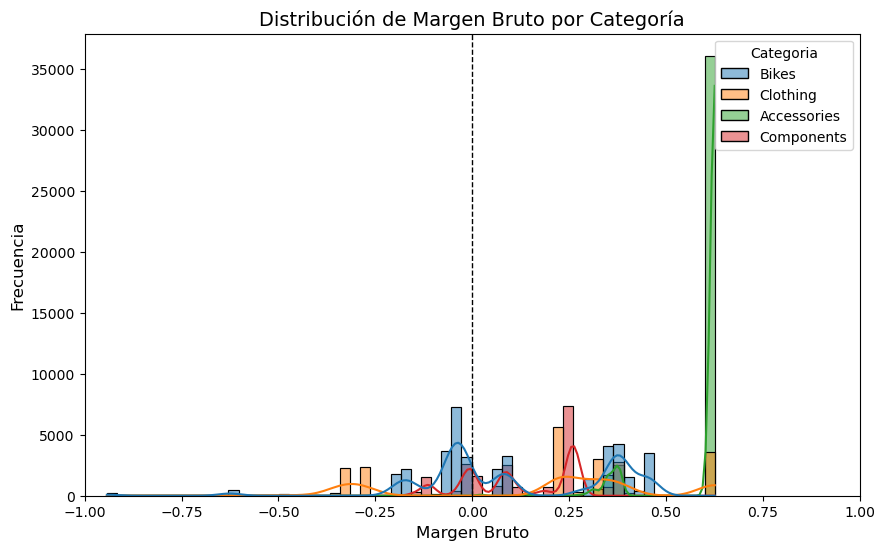

In [432]:
plt.figure(figsize=(10, 6))  
sns.histplot(
    data=rentabilidad_global,
    x="MargenBruto",
    hue="Categoria",
    kde=True, 
    bins=60,  
    alpha=0.5
)

plt.xlim(-1, 1)
plt.title('Distribución de Margen Bruto por Categoría', fontsize=14)
plt.xlabel('Margen Bruto', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)

plt.show()

## MARGEN GLOBAL ANUAL

In [475]:
margen_global_anual = rentabilidad_global.groupby(["Year", "Categoria"]).agg({
    "Ingresos": "sum",
    "Costes": "sum",
    "Beneficio": "sum"
}).reset_index()

# Calcular el margen bruto sobre los totales
margen_global_anual["MargenBruto"] = (margen_global_anual["Ingresos"] - margen_global_anual["Costes"]) / margen_global_anual["Ingresos"]
margen_global_anual

,Year,Categoria,Ingresos,Costes,Beneficio,MargenBruto
0,2011,Accessories,2.082077e+04,1.350506e+04,7.315712e+03,0.351366
1,2011,Bikes,1.183196e+07,1.024704e+07,1.584920e+06,0.133952
2,2011,Clothing,3.603148e+04,4.559335e+04,-9.561876e+03,-0.265376
3,2011,Components,6.391730e+05,6.400689e+05,-8.958766e+02,-0.001402
4,2012,Accessories,9.687677e+04,6.561010e+04,3.126667e+04,0.322747
5,2012,Bikes,2.654858e+07,2.494250e+07,1.606072e+06,0.060496
6,2012,Clothing,5.139039e+05,4.420699e+05,7.183408e+04,0.139781
7,2012,Components,3.697527e+06,3.616078e+06,8.144838e+04,0.022028
8,2013,Accessories,6.466849e+05,3.290312e+05,3.176537e+05,0.491203
9,2013,Bikes,3.584913e+07,3.347023e+07,2.378894e+06,0.066358


## Evolución del margen bruto

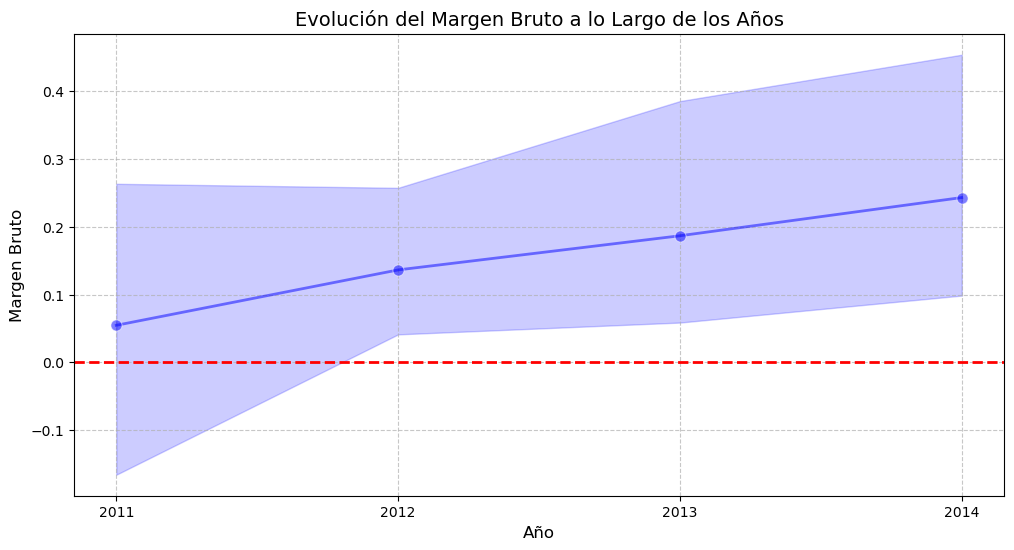

In [477]:

plt.figure(figsize=(12, 6))  # Ajustamos el tamaño del gráfico

sns.lineplot(
    data=margen_global_anual,
    x="Year",
    y="MargenBruto",
    color='blue',  
    linewidth=2,  
    marker='o',  
    markersize=8,  
    linestyle='-',  
    alpha=0.5  
)

plt.title("Evolución del Margen Bruto a lo Largo de los Años", fontsize=14)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Margen Bruto', fontsize=12)
# Establecemos que solo aparezcan los años enteros, eliminamos los valores intermedios (como 2011.5, 2012.5, etc.)
years = margen_anual['Year'].unique()
plt.xticks(years)  
plt.grid(True, linestyle='--', alpha=0.7)  # Añadimos una cuadrícula discontinua para mejorar la visualización
# Añadir una línea de referencia en Y=0
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)  # Línea horizontal discontinua en 0

plt.show()
